In [3]:
import collections
import typing
import itertools
import warnings
import functools

import pandas as pd
import numpy as np
import networkx as nx

import matplotlib.pyplot as pl
import seaborn as sns

from matplotlib.animation import FuncAnimation

sns.set_style("whitegrid")

pd.set_option('max_colwidth', None)
np.set_printoptions(edgeitems=30, linewidth=1000)

warnings.simplefilter(action='ignore', category=FutureWarning)

# Recsys overwiew demo

In [4]:
DATA_FILE = "/Users/n.anokhin/Documents/data/recsys-overview/data.csv"

ARTISTS = [
    "Artik & Asti",
    "Моргенштерн",
    "Мари Краймбрери",
    "Олег Газманов",
    "Григорий Лепс",
    "Баста",
    "Леонид Агутин",
    "Полина Гагарина",
    "Пелагея",
    "Елена Ваенга",
    "Taylor Swift",
    "Ed Sheeran",
    "Billie Eilish",
    "Adele",
    "Drake",
    "The Weekend",
    "Halsey",
    "Khalid",
    "The KID Laroi",
    "Machine Gun Kelly",
    "Michael Jackson",
    "Madonna",
    "Prince",
    "The Queen",
    "David Bowie",
]

In [5]:
answers = pd.read_csv(
    DATA_FILE, 
    names=["time", "answer"], 
    skiprows=1,
)

answers["artists"] = answers["answer"].map(lambda answer: [
    artist 
    for artist 
    in answer.split(", ")
    if artist in ARTISTS
])

answers.drop(["answer", "time"], axis=1, inplace=True)

answers.head(3)

,artists
0,"[Баста, Ed Sheeran, Billie Eilish, The Queen, Моргенштерн]"
1,"[The Queen, Michael Jackson]"
2,"[The Queen, Billie Eilish, Полина Гагарина, Adele, Баста, Леонид Агутин, Khalid, Artik & Asti, Taylor Swift, Мари Краймбрери, Ed Sheeran]"


In [6]:
def answers_to_pairs(answers: pd.DataFrame, column: str="artists") -> pd.DataFrame:
    
    def _answers_to_pairs(artists: typing.List[str]):
        return list(itertools.combinations(sorted(artists), 2))

    pairs = { 
        pair : 0 
        for pair
        in itertools.combinations(sorted(ARTISTS), 2)
    }
    for user_id, row in answers.iterrows():
        for pair in _answers_to_pairs(row[column]):
            pairs[pair] += 1
            
    return pairs

## Chose edge threshold

In [7]:
random_pairs = answers_to_pairs(
    answers.assign(
        random=answers["artists"].map(lambda artists: np.random.choice(ARTISTS, size=len(artists), replace=False))
    ), 
    "random"
)

empirical = np.mean(list(random_pairs.values()))

n_answers_pairs = answers["artists"].map(lambda artists: 0.5 * len(artists) * (len(artists) - 1)).sum()
n_all_pairs = 0.5 * len(ARTISTS) * (len(ARTISTS) - 1)

threshold = 1.0 * n_answers_pairs / n_all_pairs

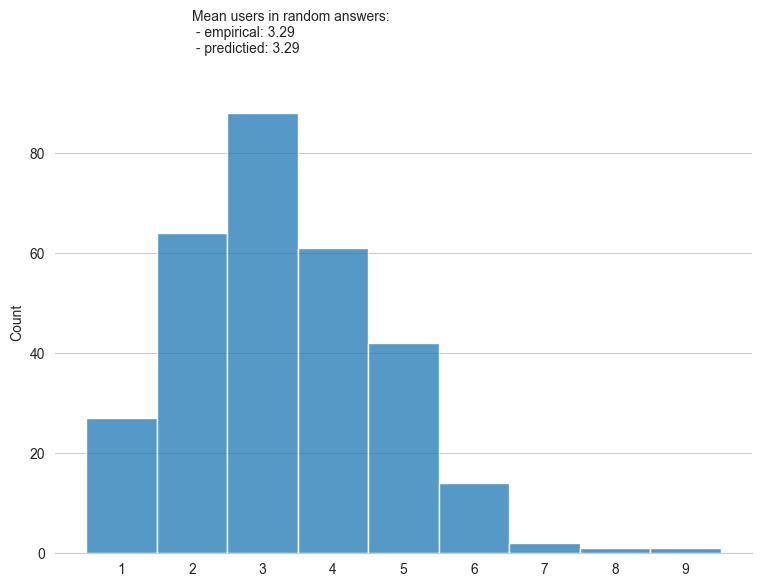

In [8]:
figure, ax = pl.subplots(figsize=(9, 6))

user_counts = list(random_pairs.values())
sns.histplot(user_counts, discrete=True, ax=ax)

ax.text(
    2, 
    100, 
    f"Mean users in random answers:\n - empirical: {empirical:.3}\n - predictied: {threshold:.3}"
)

ax.set_xticks(sorted(np.unique(user_counts)))

ax.spines[['left', 'right', 'top']].set_visible(False)
ax.xaxis.grid(False)

figure.savefig("images/user_counts.png")

## Draw random walks graph

In [9]:
COLORMAP = pl.cm.cool
COLORMAP_OFFSET = 0.25


def create_graph(answers, threshold):
    pairs = answers_to_pairs(answers)

    edges = [
        pair
        for pair, user_count
        in pairs.items()
        if user_count > threshold
    ] + [(artist, artist)
         for artist
         in ARTISTS
    ]

    graph = nx.Graph()
    graph.add_nodes_from(ARTISTS)
    graph.add_edges_from(edges)
    
    return graph


def p_next(s_current, s_initial, c):
    return c * np.dot(s_current, transition_matrix) + (1 - c) * s_initial


def s_next(s_current, s_initial, c):
    p = p_next(s_current, s_initial, c)
    return np.random.multinomial(1, p)


def generate_random_walk(s_initial, c, n):
    random_walk = np.zeros((n, len(ARTISTS)))
    random_walk[0] = np.random.multinomial(1, s_initial)
    
    for j in range(1, n):
        random_walk[j] = s_next(random_walk[j-1], s_initial, c)
        
    return random_walk


def plot_graph(graph, ax, initial=[], *args, **kwargs):
    pos = nx.spring_layout(graph, k=7.5/np.sqrt(len(ARTISTS)))
    # pos = nx.circular_layout(graph)
    
    nodes = nx.draw_networkx_nodes(
        graph, 
        pos, 
        ax=ax, 
        node_size=500, 
        node_color=[COLORMAP(1 - COLORMAP_OFFSET) for _ in ARTISTS],
        *args, 
        **kwargs
    )
    
    edges = nx.draw_networkx_edges(
        graph, 
        pos, 
        edgelist=[(s, d) for s, d in graph.edges if s != d],
        ax=ax, 
        width=0.5, 
        *args,
        **kwargs
    )
    
    nx.draw_networkx_labels(
        graph,
        pos, 
        labels={artist: artist for artist in graph if artist not in initial},
        font_color="blue",
        *args, 
        **kwargs
    )
    
    nx.draw_networkx_labels(
        graph, 
        pos, 
        labels={artist: artist for artist in graph if artist in initial},
        font_color="black",
        font_weight="bold",
        *args, 
        **kwargs
    )
    
    ax.axis('off')
    
    return nodes, edges

In [10]:
graph = create_graph(answers, threshold)

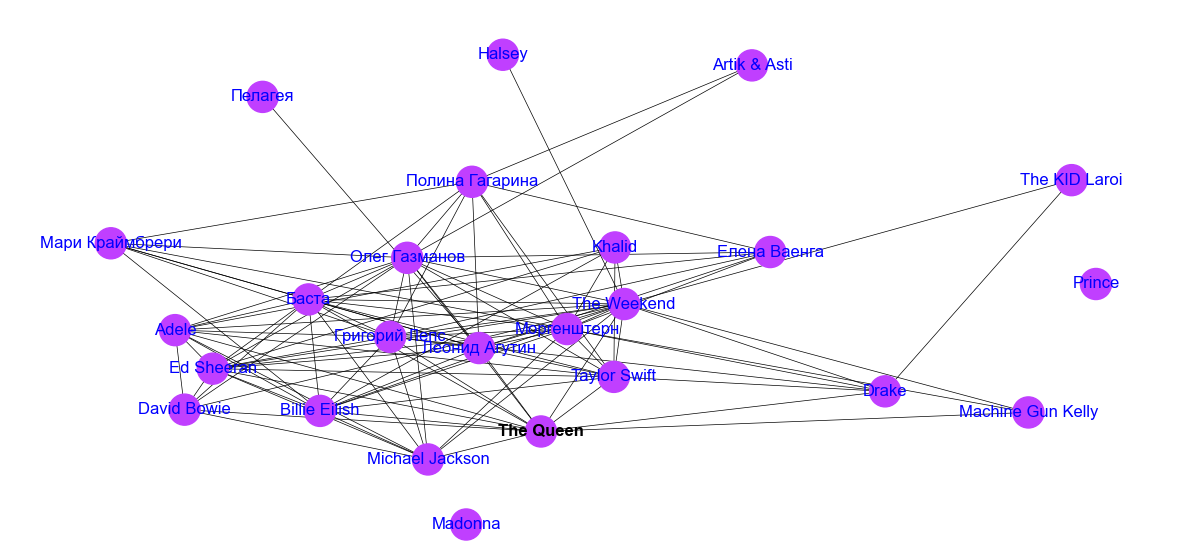

In [11]:
figure, ax = pl.subplots(figsize=(15, 7))
ax.axis("off")

nodes, _ = plot_graph(graph, ax, ["The Queen"])
nodes.set_cmap(COLORMAP)

figure.savefig("images/graph.png")

In [12]:
def animate_random_walk(graph, random_walk, initial, pos=None, *args, **kwargs):
    figure, ax = pl.subplots(figsize=(13, 7))
    
    nodes, edges = plot_graph(graph, ax, initial)
    title = ax.set_title("Random walk")

    def update(ii):
        nodes.set_cmap(COLORMAP)
        nodes.set_array(
            [[COLORMAP_OFFSET, 1 - COLORMAP_OFFSET][int(j)] for j in random_walk[ii]]
        )
        nodes.set_sizes(
            10000 * random_walk[:ii].sum(axis=0) / (random_walk[:ii+1].sum())
        )
        title.set_text(f"Random walk step {ii}")
        return nodes,

    animation = FuncAnimation(figure, update, interval=20, frames=len(random_walk), blit=True)
    
    return animation

In [13]:
adjacency_matrix = np.asarray(nx.adjacency_matrix(graph).todense())
transition_matrix = adjacency_matrix / adjacency_matrix.sum(axis=1)[:, np.newaxis]

initial = [
    "Мари Краймбрери",
    "Моргенштерн",
]

s_initial = functools.reduce(
    lambda mask_1, mask_2: mask_1 + mask_2,
    [(np.array(graph.nodes) == artist).astype(float) for artist in initial],
    np.zeros(len(ARTISTS))
)
s_initial = s_initial / s_initial.sum()

c = 0.99

random_walk = generate_random_walk(s_initial, c, 100000)

CPU times: user 16 s, sys: 1.01 s, total: 17 s
Wall time: 23.9 s


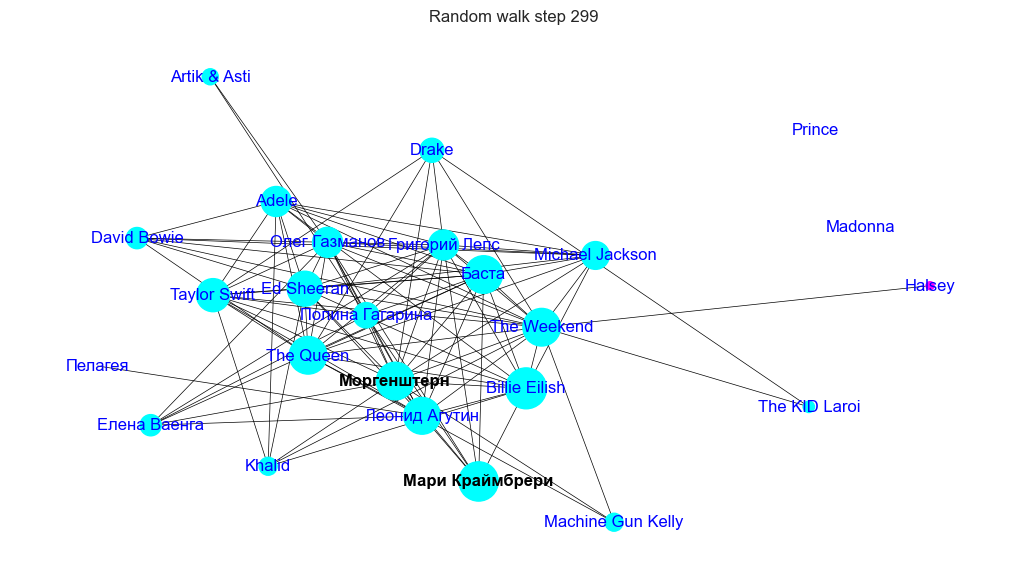

In [14]:
%%time

animation = animate_random_walk(graph, random_walk[:300], initial)
animation.save('images/random_walk.gif', savefig_kwargs={'facecolor':'white'}, fps=5.0)

## Compare solved and random walk probabilities

In [15]:
walk_frequencies = random_walk.sum(axis=0) / random_walk.sum()
solved_frequencies = np.dot((1 - c) * s_initial, np.linalg.inv(np.eye(len(ARTISTS)) - c * transition_matrix))

In [16]:
frequencies = pd.DataFrame(list(zip(graph.nodes, walk_frequencies, solved_frequencies)), columns=["artist", "walk frequency", "solved frequency"])

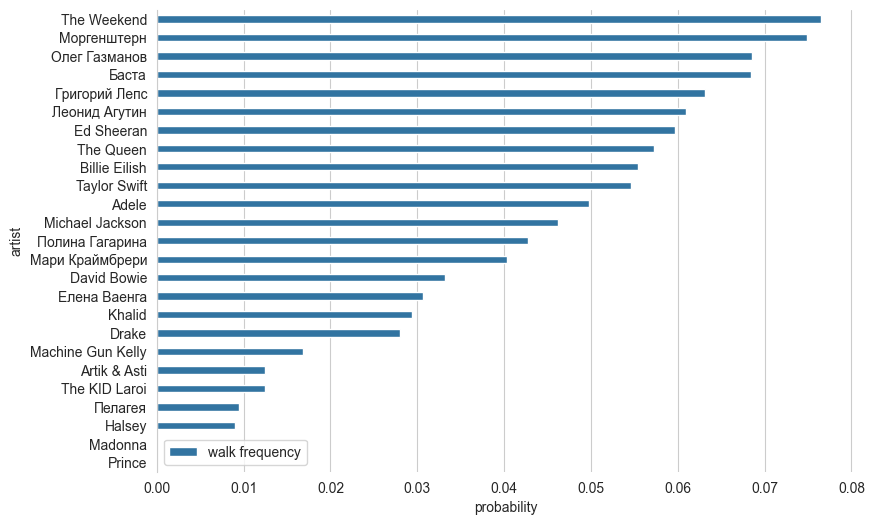

In [17]:
figure, ax = pl.subplots(figsize=(9, 6))

sns.barplot(
    (frequencies[["artist", "walk frequency"]]
         .sort_values("walk frequency", ascending=False)
         .melt(id_vars="artist")
         .rename({"value": "probability", "variable": "source"}, axis=1)
    ),
    x="probability",
    y="artist",
    hue="source",
    width=0.4,
    ax=ax,
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)

ax.spines[['bottom', 'right', 'top']].set_visible(False)

figure.savefig("images/recommendations-1.png")

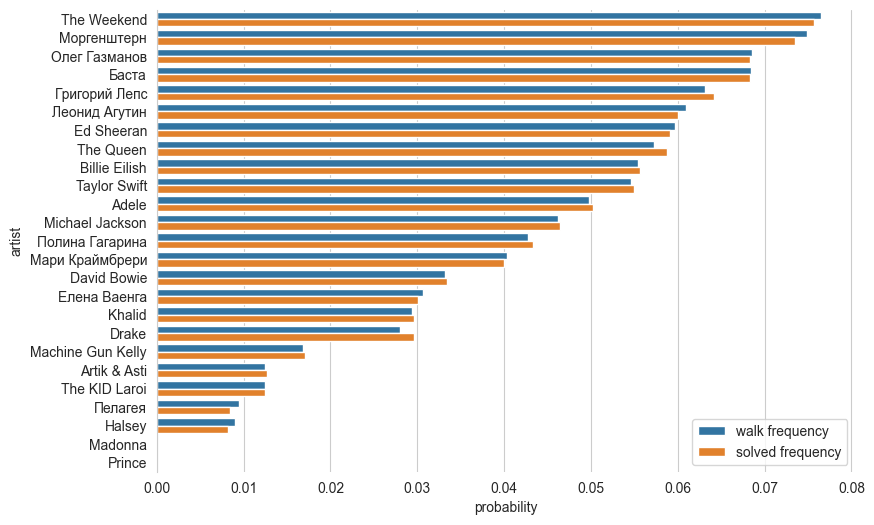

In [18]:
figure, ax = pl.subplots(figsize=(9, 6))

sns.barplot(
    (frequencies
         .sort_values("walk frequency", ascending=False)
         .melt(id_vars="artist")
         .rename({"value": "probability", "variable": "source"}, axis=1)
    ), 
    x="probability",
    y="artist", 
    hue="source", 
    ax=ax,
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)

ax.spines[['bottom', 'right', 'top']].set_visible(False)

figure.savefig("images/recommendations-2.png")